Нейронный перенос стиля с Pytorch
============================
**Aвтор**: `Alexis Jacq <https://alexis-jacq.github.io>` <br />
**Адаптивный перевод**: `Zueva Nadya <https://github.com/nestyme>` <br />
Введение
------------

В этом ноутбуке объясняется и показывается, как работает алгоритм переноса стиля 

`Neural-Style <https://arxiv.org/abs/1508.06576>` 

Леона А. Гатиса, Александра С. Эккера и Маттиаса Бетге.


**Нейронный перенос стиля** -- это алгоритм, который принимает контент-изображение (например, черепаху), стиль-изображение (например, картинку известного художника) и возвращает изображение, которое будто бы нарисовано тем художником:



**Как это работает?**

Всего есть три картинки: вход, стиль и контент. 
Определим два расстояния: 
- $D_S$ - оно определяет на сколько разные стили у двух произвольных картинок.
- $D_C$ - оно определяет на сколько разнится контент у двух произвольных картинок.

задача сети - минимизировать $D_S$ от входной картинки до стиля и $D_C$ от входной картиники до контента.<br />
В качестве входа обычно берется зашумленная к
артинка контента.


Это все что нам понадобится:

In [1]:
!pip3 install torch torchvision
!pip3 install pillow==4.1.1

     |████████████████████████████████| 5.7MB 5.8MB/s 
     |████████████████████████████████| 112kB 49.7MB/s 
  Created wheel for olefile: filename=olefile-0.46-py2.py3-none-any.whl size=35416 sha256=258fd51498ee54194b9fd6c47bd2b3e3e05b30320efc758c13da503eb64b44f9
  Stored in directory: /root/.cache/pip/wheels/4b/f4/11/bc4166107c27f07fd7bba707ffcb439619197638a1ac986df3
Successfully built olefile
ERROR: scikit-image 0.16.2 has requirement pillow>=4.3.0, but you'll have pillow 4.1.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [1]:
%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/NST/images/

content2.jpg  style12.jpg  style18.jpg	style22.png  style7.jpg
content3.jpg  style13.jpg  style19.jpg	style3.jpg   style8.jpg
content4.jpg  style14.jpg  style20.jpg	style4.jpg   style9.jpg
input.jpg     style15.jpg  style21.jpg	style5.jpg   style.jpg
style10.jpg   style17.jpg  style22.jpg	style6.jpg   tyle11.jpg


**Загрузка изображений**

Нам понадобятся картинки стиля и контента, так что загрузим их.<br />
Чтобы упростить реализацию, начнем с контента и стиля одного размера. Затем мы масштабируем их до требуемых размеров выходного изображения.

Примеры изображений лежат в папке `Images` на гуглдиске

Вы можете добавить туда свои собственные изображения -- главное, чтобы они были одного размера

In [4]:
imsize = 256  

loader = transforms.Compose([
    transforms.Resize(imsize),  # нормируем размер изображения
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  # превращаем в удобный формат

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader(image)).unsqueeze(0)
    #return image.to(device, torch.float)
    return image.to(device)

dtype = torch.cuda.FloatTensor
style_img = image_loader("/content/drive/MyDrive/NST/images/style5.jpg").type(dtype)# as well as here
style2_img = image_loader("/content/drive/MyDrive/NST/images/style.jpg").type(dtype)
content_img = image_loader("/content/drive/MyDrive/NST/images/content2.jpg").type(dtype)#измените путь на тот который у вас.
#mask = torch.tril(torch.ones(1, 3, 128, 128))
#mask2 = torch.triu(torch.ones(1, 3, 128, 128))

Выведем то, что было загружено

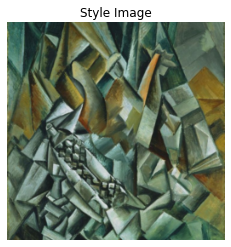

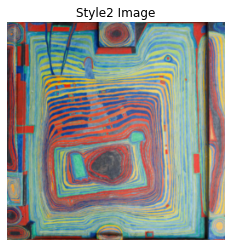

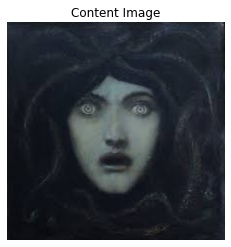

In [36]:
unloader = transforms.ToPILImage() # тензор в кратинку  

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()    # функция для отрисовки изображения
    image = image.view(3, imsize, imsize)
    image = unloader(image)
    plt.axis('off')
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

# отрисовка

plt.figure()
plt.axis('off')
imshow(style_img, title='Style Image')

plt.figure()
plt.axis('off')
imshow(style2_img, title='Style2 Image')

plt.figure()
plt.axis('off')
imshow(content_img, title='Content Image')

# plt.figure()
# imshow(mask, title='Mask Image')

# plt.figure()
# imshow(mask2, title='Mask2 Image')

Теперь нужно создать функции, которые будут вычислять расстояния ( $D_C$ и $D_S$). <br />
Они будут выполенены в виде слоев, чтобы брать по ним автоградиент.

$D_S$ - средняя квадратичная ощибка input'а и target'а

In [28]:
class ContentLoss(nn.Module):

    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output

Матрица грама позволяет учесть не только сами значения feature map'а, но и кореляцию фич друг с другом. <br /> Это нужно для того, чтобы сделать акцент на встречаемость фич с друг другом, а не на их геометрическом положении. <br />
Полное понимание этого момента можно получить с помощью [этого](https://arxiv.org/pdf/1508.06576.pdf)  и [этого](https://m.habr.com/company/mailru/blog/306916/).

Таким образом:

$D_S$  = $\sum$($G_{ij}$($img_1$) - $G_{ij}$($img_2$)$)^{2}$

Сначала задаем спрособ подсчета матрицы грама: Это просто тензорное тензорное произведение вектора выхода уровня самого на себя.<br /> Однка наш выход - не вектор. В этом случае операция тоже возможна,<br /> но мы получим тензор третьего ранга. Поэтому перед перемножением выход нужно привести к форме вектора.<br />

In [8]:
def gram_matrix(input):
        #batch_size , h, w, f_map_num = input.size()  # batch size(=1)
        batch_size, f_map_num, h, w = input.size()
        # b=number of feature maps
        # (h,w)=dimensions of a feature map (N=h*w)

        #features = input.view(batch_size * h, w * f_map_num)  # resise F_XL into \hat F_XL
        features = input.view(batch_size * f_map_num, h * w)#получаем f_map_num векторов, которые потом перемножаем друг с другом, что и есть G
        #матрица размером к-во фиче мапов на к-во пикселейб а к-во пикселей есть h*w, batch-size вообще можно убрать, т.к. он = 1

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(batch_size * f_map_num * h * w)

Матрица грама готова, теперь нужно лишь реализовать MSE

In [ ]:
#после сверточного слоя выходит тензор размером b x out_channels x h x w

In [21]:
# mask_img = torch.tril(torch.ones(1, 3, 8, 8))
# mask_img.size()

In [22]:
#mask_img

In [23]:
# mask_img = torch.triu(torch.ones(1, 3, 8, 8))
# mask_img.size()

In [24]:
#mask_img

In [25]:
# mask_img = nn.functional.interpolate(mask_img, size=(4, 4))
# mask_img.size()

In [26]:
#mask_img

In [38]:
class StyleLoss(nn.Module):

    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        #print(self.target.size())
        self.weight = weight

    def forward(self, input):
        self.output = input.clone()
        #self.G = self.gram(input)
        self.G = gram_matrix(input)
        #print(self.G.size())
        self.G.mul_(self.weight)
        #print(self.G.size())
        #self.loss = self.criterion(self.G, self.target)
        self.loss = F.mse_loss(self.G, self.target)
        return self.output

При тренировке VGG каждое изображение на котором она обучалась было нормировано по всем каналам (RGB). Если мы хотим изпользовать ее для нашей модели, то мы должны реализовать нормировку и для наших изображений тоже.


In [11]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [12]:
class Normalization(nn.Module): #коэффициенты нормализации, чтобы vgg правилно извлекала фичи из изображения
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

Теперь соберем это все в одну функцию, которая отдаст на выходе модель и две функции потерь 

Определим после каких уровней мы будем счиатать ошибки стиля, а после каких ошибки контента

In [13]:
content_layers_default =['conv_4']
#content_layers_default2 = ['conv_1', 'conv_2', 'conv_4', 'conv_6', 'conv_8', 'conv_10', 'conv_12']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
#style_layers_default2 = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_6', 'conv_7', 'conv_8', 'conv_9', 'conv_10', 'conv_11', 'conv_12']
#иногда даже вообще зануляют лосс контента и считают только лосс стиля

Определим предобученную модель

In [14]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [39]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img, style2_img, content_img, weight, weight2,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default, content_weight=1):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        #content_losses2 = []
        style_losses = []
        style_losses2 = []
        gram = GramMatrix()
        #model = model.cuda()
        gram = gram.cuda()

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 1
        for layer in list(cnn):
            if isinstance(layer, nn.Conv2d):
                name = "conv_" + str(i)
                model.add_module(name, layer)

                if name in content_layers:
                    target = model(content_img).clone()
                    content_loss = ContentLoss(target, content_weight)
                    model.add_module("content_loss_" + str(i), content_loss)
                    content_losses.append(content_loss)

                if name in style_layers:
                    target_feature = model(style_img).clone()
                    target_feature_gram = gram(target_feature)
                    style_loss = StyleLoss(target_feature_gram, weight)
                    model.add_module("style_loss_" + str(i), style_loss)
                    style_losses.append(style_loss)

                    target_feature2 = model(style2_img).clone()
                    target_feature_gram2 = gram(target_feature2)
                    style_loss2 = StyleLoss(target_feature_gram2, weight2)
                    model.add_module("style_loss2_" + str(i), style_loss2)
                    style_losses2.append(style_loss2)

            if isinstance(layer, nn.ReLU):
              name = "relu_" + str(i)
              model.add_module(name, layer)

              if name in content_layers:
                    target = model(content_img).clone()
                    content_loss = ContentLoss(target, content_weight)
                    model.add_module("content_loss_" + str(i), content_loss)
                    content_losses.append(content_loss)

              i += 1

            if isinstance(layer, nn.MaxPool2d):
                name = "pool_" + str(i)
                model.add_module(name, layer)

        # now we trim off the layers after the last content and style losses
        #выбрасываем все уровни после последенего styel loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]#мы раскладываем вгг на уровни, берем уровень, подсоединяем к нему стайл лосс, смотрим,есть ли этот уровень в списке уровней, к которым мы присоединяем стайл лосс
        #потом аналогично с контент лоссом - присоединяем и смотрим, есть ли в списке, потом присоедияем следующий уровень вгг и т.д.
        #и в итоге мы выкидываем последний уровень сети, как раз в этой строчке, т.к. нам фактически без разницы, что она там выдает

        return model, style_losses, style_losses2, content_losses

In [16]:
def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

Дальше стандартный цикл обучения, но что это за closure?<br /> Это функция, которая вызывается во время каждого прохода, чтобы пересчитать loss. Без нее ничего не получется так как у нас своя функция ошибки

In [41]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_img, style2_img, input_img, weight, weight2, num_steps=800,
                        content_weight=10):
        """Run the style transfer."""
        print('Building the style transfer model..')
        weight = 1000
        weight2 = 700
        model, style_losses, style_losses2, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img, style2_img, content_img, weight, weight2)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)#вот тут в модель попадает инпут

                style_score = 0
                style_score2 = 0
                content_score = 0

                for sl in style_losses:
                    #print(sl.loss)
                    style_score += sl.loss
                    #print(style_score)
                for sl in style_losses2:
                    style_score2 += sl.loss
                for cl in content_losses:
                    content_score +=cl.loss
                
                #взвешивание ощибки
                style_score *= weight
                style_score2 *= weight2
                content_score *= content_weight

                loss = style_score + style_score2 + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Style2 Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score, style_score2, content_score))
                    print()

                return style_score + style_score2 + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

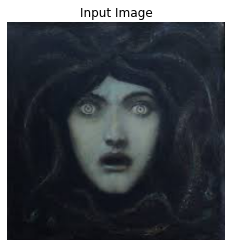

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 5473930.000000 Style2 Loss : 15482050.000000 Content Loss: 230.476105

run [100]:
Style Loss : 5326725.500000 Style2 Loss : 15382177.000000 Content Loss: 246.585541

run [150]:
Style Loss : 5258996.000000 Style2 Loss : 15399419.000000 Content Loss: 254.883881

run [200]:
Style Loss : 5291256.000000 Style2 Loss : 15353054.000000 Content Loss: 260.191772

run [250]:
Style Loss : 5273690.000000 Style2 Loss : 15364288.000000 Content Loss: 263.063904

run [300]:
Style Loss : 5267660.000000 Style2 Loss : 15368124.000000 Content Loss: 264.414795

run [350]:
Style Loss : 5269641.500000 Style2 Loss : 15365038.000000 Content Loss: 265.453674

run [400]:
Style Loss : 5269941.000000 Style2 Loss : 15364103.000000 Content Loss: 266.032135

run [450]:
Style Loss : 5269641.000000 Style2 Loss : 15364007.000000 Content Loss: 266.480164

run [500]:
Style Loss : 5269106.500000 Style2 Loss : 15364267.000000 Content Loss: 266.852966

run [550]:
Style Loss : 5268960.000000 Style2 Loss 

In [42]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
plt.axis('off')
imshow(input_img, title='Input Image')
weight = 1000
weight2 = 700
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, style2_img, input_img, weight, weight2)

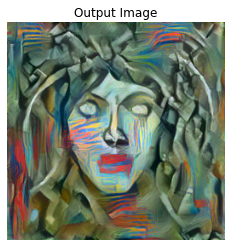

In [43]:
plt.figure()
imshow(output, title='Output Image')
plt.ioff()
plt.show()

In [ ]:
torch.cuda.empty_cache()